In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 
from matplotlib.colors import LinearSegmentedColormap
import datetime

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV

from sklearn.feature_selection import SelectKBest, SelectPercentile    
from sklearn.feature_selection import chi2, f_classif, f_regression
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
# !pip install skfeature-chappers -y
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import SelectFromModel
from PIL import Image

from sklearn.model_selection import StratifiedKFold, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, fbeta_score, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

pd.set_option("display.max_columns", None)

In [150]:
random_state = 123
sns.set()
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 98

colors = ['#646E78','#d1d646', '#97bf78', '#7ca282', '#61858c', '#466796', '#8967b5', '#b363b9', '#d560bc', '#f25dbf']

show_plots = True
save_plots = False
img_counter = 0
kaggle = False
div_colors = ['#466796','#9ca9c3','#f1f1f1','#e5e39f','#d1d646']


def log_transform_data(df, col):
    return np.log1p(df[col])

## Function to plot histograms of numeric features for specified dataframe
def plotHistograms(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if show_plots:
        fig, axes = plt.subplots(rows, ceil(len(features) / rows), \
                             figsize=(11, 3*rows), constrained_layout=True, sharey=True)
        
        for ax, feat in zip(axes.flatten(), features):
            ax.set_title(feat, y=1)
            ax.legend()
            df.pivot(columns='Buy')[feat].plot(kind = 'hist', stacked=True, ax=ax, color=colors[0:2])
    
        if (len(axes.flatten())) > len(features):
            for f in range(len(axes.flatten())-len(features)):
                axes.flatten()[(f+1)*-1].axis('off')
        plt.suptitle(title)
        plt.show()
    else:
        print("show_plots is currently set to False")

## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if show_plots:
        fig = plt.figure(figsize=(11, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns='IsCanceled')[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=colors[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df['IsCanceled']==0,feat], ax=axs[1], color=colors[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df['IsCanceled']==1,feat], ax=axs[2], color=colors[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if save_plots:
            save_fig(title, fig)
    else:
        print("show_plots is currently set to False")




def save_fig(title, fig, dest='img/', img_counter=img_counter):
    img_counter = img_counter + 1
    fn = dest + str(img_counter) + '_' + title.replace(' ','-') + '.png'
    fig.savefig(fn, bbox_inches='tight')
    
def plot_cat_counts(df, features, rows=6, title = "Count Distributions of Categorical Variables"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,'IsCanceled']).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=colors)

            df2 = df.groupby([feat,'IsCanceled']).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=colors)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if save_plots:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

In [151]:
# data_train_num = data_train.select_dtypes(include=np.number).set_index(data_train.index)
# data_train_cat = data_train.select_dtypes(exclude=np.number).set_index(data_train.index).drop("Buy", axis = 1)
# num_feat = data_train_num.columns.tolist()
# cat_feat = data_train_cat.columns.tolist()

# data_test_num = data_test.select_dtypes(include=np.number).set_index(data_test.index)
# data_test_cat = data_test.select_dtypes(exclude=np.number).set_index(data_test.index)

In [152]:
# original_cat_feats = data_train.select_dtypes(exclude=np.number).columns.tolist()

# plot_cat_counts(data_train, original_cat_feats)

In [153]:
# plot_histograms_boxplots(data_train, num_feat, rows=4)

## IMPORT AND EXPLORATION

In [154]:
data = pd.read_csv("H2.csv")
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [156]:
# Feature Engineering
data["DurationOfStay"] = data["StaysInWeekNights"] + data["StaysInWeekendNights"]
data["TotalValue"] = data["DurationOfStay"] * data["ADR"]
data["ArrivalDateMonthNumber"] = data["ArrivalDateMonth"].apply(lambda x : datetime.datetime.strptime(x, "%B").month).astype("str")
data["ArrivalDate"] = data["ArrivalDateYear"].astype(str) + "-" + data["ArrivalDateMonthNumber"].astype(str) + "-" + data["ArrivalDateDayOfMonth"].astype(str)
data["ArrivalDate"] = pd.to_datetime(data["ArrivalDate"])
data['ArrivalDayOfWeek'] = data['ArrivalDate'].dt.dayofweek.astype('str')
data.drop("ArrivalDateMonth", inplace = True, axis = 1)
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek
0,0,6,2015,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2,0.00,7,2015-07-01,2
1,1,88,2015,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01,4,306.00,7,2015-07-01,2
2,1,65,2015,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30,4,272.00,7,2015-07-01,2
3,1,92,2015,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23,6,459.00,7,2015-07-01,2
4,1,100,2015,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02,2,153.00,7,2015-07-02,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,672.98,8,2017-08-30,2
79326,0,102,2017,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,1578.01,8,2017-08-31,3
79327,0,34,2017,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,1103.97,8,2017-08-31,3
79328,0,109,2017,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,730.80,8,2017-08-31,3


In [157]:
# Feature Engineering
data["ReservationStatusDate"] = pd.to_datetime(data["ReservationStatusDate"])

data['ReservationDayOfMonth'] = data['ReservationStatusDate'].dt.day.astype('str')
data['ReservationWeekOfYear'] = data['ReservationStatusDate'].dt.weekofyear.astype('str')
data['ReservationMonth'] = data['ReservationStatusDate'].dt.month.astype('str')
data['ReservationDayOfWeek'] = data['ReservationStatusDate'].dt.dayofweek.astype('str')

data["IsRoomChanged"] = (data["AssignedRoomType"] != data["ReservedRoomType"]).astype("int")

In [158]:
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2,0.00,7,2015-07-01,2,3,27,7,4,0
1,1,88,2015,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01,4,306.00,7,2015-07-01,2,1,27,7,2,0
2,1,65,2015,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30,4,272.00,7,2015-07-01,2,30,18,4,3,0
3,1,92,2015,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23,6,459.00,7,2015-07-01,2,23,26,6,1,0
4,1,100,2015,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02,2,153.00,7,2015-07-02,3,2,14,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,672.98,8,2017-08-30,2,6,36,9,2,0
79326,0,102,2017,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,1578.01,8,2017-08-31,3,7,36,9,3,0
79327,0,34,2017,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,1103.97,8,2017-08-31,3,7,36,9,3,0
79328,0,109,2017,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,730.80,8,2017-08-31,3,7,36,9,3,0


In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   IsCanceled                   79330 non-null  int64         
 1   LeadTime                     79330 non-null  int64         
 2   ArrivalDateYear              79330 non-null  int64         
 3   ArrivalDateWeekNumber        79330 non-null  int64         
 4   ArrivalDateDayOfMonth        79330 non-null  int64         
 5   StaysInWeekendNights         79330 non-null  int64         
 6   StaysInWeekNights            79330 non-null  int64         
 7   Adults                       79330 non-null  int64         
 8   Children                     79326 non-null  float64       
 9   Babies                       79330 non-null  int64         
 10  Meal                         79330 non-null  object        
 11  Country                      79306 non-nu

In [160]:
# saving numeric features into a list
numeric_features = data.select_dtypes(include=np.number).set_index(data.index).columns.tolist()
data[numeric_features]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0.0,0,0,0,0,0,0,0.00,0,0,2,0.00,0
1,1,88,2015,27,1,0,4,2,0.0,0,0,0,0,0,0,76.50,0,1,4,306.00,0
2,1,65,2015,27,1,0,4,1,0.0,0,0,0,0,0,0,68.00,0,1,4,272.00,0
3,1,92,2015,27,1,2,4,2,0.0,0,0,0,0,0,0,76.50,0,2,6,459.00,0
4,1,100,2015,27,2,0,2,2,0.0,0,0,0,0,0,0,76.50,0,1,2,153.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0,7,672.98,0
79326,0,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2,7,1578.01,0
79327,0,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4,7,1103.97,0
79328,0,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0,7,730.80,0


In [161]:
# metric_features is a subset of numeric_features

to_discard = ["ArrivalDateYear", "ArrivalDateDayOfMonth", "IsRepeatedGuest", "IsCanceled", "IsRoomChanged"]

metric_features = numeric_features.copy()
for feat in to_discard:
    metric_features.remove(feat)

In [162]:
categorical_features = data.select_dtypes(exclude=np.number).set_index(data.index).columns.tolist()

#adding the numeric non metric features
categorical_features.extend(to_discard)

data[categorical_features]

,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,ArrivalDateYear,ArrivalDateDayOfMonth,IsRepeatedGuest,IsCanceled,IsRoomChanged
0,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,6,NULL,Transient,Check-Out,2015-07-03,7,2015-07-01,2,3,27,7,4,2015,1,0,0,0
1,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-07-01,7,2015-07-01,2,1,27,7,2,2015,1,0,1,0
2,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-04-30,7,2015-07-01,2,30,18,4,3,2015,1,0,1,0
3,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-06-23,7,2015-07-01,2,23,26,6,1,2015,1,0,1,0
4,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-04-02,7,2015-07-02,3,2,14,4,3,2015,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,394,NULL,Transient,Check-Out,2017-09-06,8,2017-08-30,2,6,36,9,2,2017,30,0,0,0
79326,BB,FRA,Online TA,TA/TO,E,E,No Deposit,9,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0,0
79327,BB,DEU,Online TA,TA/TO,D,D,No Deposit,9,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0,0
79328,BB,GBR,Online TA,TA/TO,A,A,No Deposit,89,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0,0


In [163]:
data.describe(include="all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
IsCanceled,79330.0,NaN,NaN,NaN,NaT,NaT,0.41727,0.493111,0.0,0.0,0.0,1.0,1.0
LeadTime,79330.0,NaN,NaN,NaN,NaT,NaT,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,79330.0,NaN,NaN,NaN,NaT,NaT,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateWeekNumber,79330.0,NaN,NaN,NaN,NaT,NaT,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,79330.0,NaN,NaN,NaN,NaT,NaT,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,79330.0,NaN,NaN,NaN,NaT,NaT,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,NaN,NaN,NaN,NaT,NaT,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,NaN,NaN,NaN,NaT,NaT,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,NaN,NaN,NaN,NaT,NaT,0.09137,0.372177,0.0,0.0,0.0,0.0,3.0
Babies,79330.0,NaN,NaN,NaN,NaT,NaT,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0


### Duplicates

In [164]:
data_dup = data.copy()
print("Percentage of suspect duplicated data: " , (data_dup.duplicated().sum() / len(data)) * 100)

Percentage of suspect duplicated data:  32.65095172066053


In [165]:
duplicates = data_dup.loc[data_dup.duplicated()]
duplicates = duplicates.groupby(duplicates.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
size = duplicates.pop("size")
duplicates.insert(0, "size", size)
duplicates

,size,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
5405,179,1,277,2016,46,7,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NULL,NULL,0,Transient,100.00,0,0,Canceled,2016-04-04,3,300.00,11,2016-11-07,0,4,14,4,0,0
4180,149,1,68,2016,8,17,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,37,NULL,0,Transient,75.00,0,0,Canceled,2016-01-06,2,150.00,2,2016-02-17,2,6,1,1,2,0
5073,108,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.00,0,0,Canceled,2016-01-18,2,260.00,6,2016-06-15,2,18,3,1,0,0
4878,100,1,158,2016,22,24,0,2,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,37,NULL,31,Transient,130.00,0,0,Canceled,2016-01-18,2,260.00,5,2016-05-24,1,18,3,1,0,0
3851,99,1,34,2015,50,8,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,0,Non Refund,19,NULL,0,Transient,90.00,0,0,Canceled,2015-11-17,2,180.00,12,2015-12-08,1,17,47,11,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,1,0,59,2017,17,26,0,1,2,0.0,0,BB,CHE,Direct,Direct,0,0,0,D,D,0,No Deposit,14,NULL,0,Transient,130.50,0,2,Check-Out,2017-04-27,1,130.50,4,2017-04-26,2,27,17,4,3,0
1480,1,0,59,2017,14,6,0,3,2,0.0,0,BB,ISR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,117.00,0,2,Check-Out,2017-04-09,3,351.00,4,2017-04-06,3,9,14,4,6,0
1479,1,0,59,2017,12,23,0,1,2,0.0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,79.20,0,0,Check-Out,2017-03-24,1,79.20,3,2017-03-23,3,24,12,3,4,0
3383,1,0,409,2017,22,31,0,3,2,0.0,0,BB,AUS,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229,NULL,0,Transient-Party,112.67,0,2,Check-Out,2017-06-03,3,338.01,5,2017-05-31,2,3,22,6,5,0


In [166]:
#Exploring the day with most populated duplicates
data_dup.loc[(data_dup.ArrivalDateDayOfMonth == 7) & 
(data_dup.ArrivalDateMonthNumber == "11") & 
(data_dup.ArrivalDateYear == 2016)
]["MarketSegment"].value_counts()

Groups           215
Online TA         86
Direct             7
Offline TA/TO      5
Corporate          4
Aviation           2
Complementary      1
Name: MarketSegment, dtype: int64

In [167]:
#Exploring the day with most populated duplicates
data_dup.loc[(data_dup.ArrivalDateDayOfMonth == 7) & 
(data_dup.ArrivalDateMonthNumber == "11") & 
(data_dup.ArrivalDateYear == 2016)
]["CustomerType"].value_counts()

Transient          317
Transient-Party      3
Name: CustomerType, dtype: int64

In [168]:
data_dup[data_dup["MarketSegment"] == "Groups"].groupby(data_dup.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
# data_dup[data_dup["CustomerType"] == "Group"].groupby(data_dup.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged,size
2348,1,277,2016,46,7,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NULL,NULL,0,Transient,100.0,0,0,Canceled,2016-04-04,3,300.0,11,2016-11-07,0,4,14,4,0,0,180
1965,1,68,2016,8,17,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,37,NULL,0,Transient,75.0,0,0,Canceled,2016-01-06,2,150.0,2,2016-02-17,2,6,1,1,2,0,150
2162,1,158,2016,22,24,0,2,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,37,NULL,31,Transient,130.0,0,0,Canceled,2016-01-18,2,260.0,5,2016-05-24,1,18,3,1,0,0,101
1852,1,28,2017,9,2,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NULL,NULL,0,Transient,95.0,0,0,Canceled,2017-02-02,3,285.0,3,2017-03-02,3,2,5,2,3,0,99
2160,1,156,2017,17,26,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,37,NULL,0,Transient,100.0,0,0,Canceled,2016-11-21,3,300.0,4,2017-04-26,2,21,47,11,0,0,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,0,72,2015,37,11,0,2,2,0.0,0,HB,LUX,Groups,TA/TO,0,0,0,A,D,2,No Deposit,30,NULL,0,Transient-Party,63.0,0,0,Check-Out,2015-09-13,2,126.0,9,2015-09-11,4,13,37,9,6,1,1
975,0,72,2015,37,11,0,2,2,0.0,0,HB,LUX,Groups,TA/TO,0,0,0,A,A,0,No Deposit,30,NULL,0,Transient-Party,126.0,0,0,Check-Out,2015-09-13,2,252.0,9,2015-09-11,4,13,37,9,6,0,1
973,0,72,2015,37,11,0,2,1,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,D,0,No Deposit,30,NULL,0,Transient-Party,98.0,0,0,Check-Out,2015-09-13,2,196.0,9,2015-09-11,4,13,37,9,6,1,1
972,0,72,2015,37,11,0,2,1,0.0,0,HB,LUX,Groups,TA/TO,0,0,0,A,D,1,No Deposit,30,NULL,0,Transient-Party,98.0,0,0,Check-Out,2015-09-13,2,196.0,9,2015-09-11,4,13,37,9,6,1,1


In [169]:
#Removing duplicated records accountable to groups

# Removes all records (except one) for duplicated values with Market Segment = Groups
data_dup = data_dup[~(data_dup.duplicated(keep="first") & data_dup['MarketSegment'].eq('Groups'))]

# Removes all records (except one) for duplicated values with CustomerType = Group
# data_dup = data_dup[~(data_dup.duplicated(keep="first") & data_dup['CustomerType'].eq('Group'))]

In [170]:
# Check greater size = 1
data_dup[data_dup["MarketSegment"] == "Groups"].groupby(data_dup.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
# data_dup[data_dup["CustomerType"] == "Group"].groupby(data_dup.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged,size
0,0,0,2015,31,31,2,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient,36.0,0,0,Check-Out,2015-08-04,4,144.0,7,2015-07-31,4,4,32,8,1,0,1
1749,1,1,2015,37,6,2,0,0,0.0,0,SC,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Canceled,2015-09-05,2,0.0,9,2015-09-06,6,5,36,9,5,0,1
1751,1,1,2015,37,6,2,0,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,75.0,0,0,Canceled,2015-09-05,2,150.0,9,2015-09-06,6,5,36,9,5,0,1
1752,1,1,2015,44,28,0,3,2,0.0,0,HB,PRT,Groups,TA/TO,1,1,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,111.0,0,0,Canceled,2015-10-27,3,333.0,10,2015-10-28,2,27,44,10,1,0,1
1753,1,1,2015,53,29,0,4,2,0.0,1,BB,PRT,Groups,TA/TO,0,0,0,B,B,2,No Deposit,29,NULL,0,Transient,72.5,0,2,Canceled,2015-12-29,4,290.0,12,2015-12-29,1,29,53,12,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,0,61,2015,48,23,1,2,1,0.0,0,BB,EGY,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,70.0,0,0,Check-Out,2015-11-26,3,210.0,11,2015-11-23,0,26,48,11,3,0,1
880,0,61,2015,48,23,1,2,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,70.0,0,0,Check-Out,2015-11-26,3,210.0,11,2015-11-23,0,26,48,11,3,0,1
881,0,61,2015,48,23,1,3,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,70.0,0,0,Check-Out,2015-11-27,4,280.0,11,2015-11-23,0,27,48,11,4,0,1
882,0,61,2015,48,23,1,3,1,0.0,0,BB,TUN,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37,NULL,0,Transient-Party,70.0,0,0,Check-Out,2015-11-27,4,280.0,11,2015-11-23,0,27,48,11,4,0,1


In [171]:
print("Percentage of kept records after removal: " , (len(data_dup) / len(data)) * 100)

Percentage of kept records after removal:  85.70528173452666


In [172]:
data_dup.duplicated().sum() / len(data_dup)

0.21417855566995148

In [173]:
duplicates = data_dup.loc[data_dup.duplicated()]
duplicates = duplicates.groupby(duplicates.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
size = duplicates.pop("size")
duplicates.insert(0, "size", size)
duplicates

,size,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
4259,108,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.00,0,0,Canceled,2016-01-18,2,260.0,6,2016-06-15,2,18,3,1,0,0
3264,99,1,34,2015,50,8,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,0,Non Refund,19,NULL,0,Transient,90.00,0,0,Canceled,2015-11-17,2,180.0,12,2015-12-08,1,17,47,11,1,0
3306,98,1,38,2017,2,14,0,1,1,0.0,0,BB,PRT,Corporate,Corporate,0,0,0,A,A,0,Non Refund,NULL,67,0,Transient,75.00,0,0,Canceled,2016-12-07,1,75.0,1,2017-01-14,5,7,49,12,2,0
3555,88,1,71,2016,25,14,0,3,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,236,NULL,0,Transient,120.00,0,0,Canceled,2016-04-27,3,360.0,6,2016-06-14,1,27,17,4,2,0
4566,84,1,304,2016,45,3,0,3,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,21,NULL,0,Transient,89.00,0,0,Canceled,2016-02-01,3,267.0,11,2016-11-03,3,1,5,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,1,0,105,2016,17,17,2,1,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient-Party,96.30,0,0,Check-Out,2016-04-20,3,288.9,4,2016-04-17,6,20,16,4,2,0
1778,1,0,105,2016,17,18,1,3,2,0.0,0,BB,LUX,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,82.45,0,0,Check-Out,2016-04-22,4,329.8,4,2016-04-18,0,22,16,4,4,0
1779,1,0,105,2016,24,11,1,1,2,0.0,0,BB,ARG,Online TA,TA/TO,0,0,0,A,D,0,No Deposit,9,NULL,0,Transient,126.90,0,1,Check-Out,2016-06-13,2,253.8,6,2016-06-11,5,13,24,6,0,1
1780,1,0,105,2016,32,6,1,1,2,0.0,0,SC,MAR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,107.10,0,1,Check-Out,2016-08-08,2,214.2,8,2016-08-06,5,8,32,8,0,0


In [174]:
#Exploring the day with most populated duplicates
data_dup.loc[(data_dup.ArrivalDateDayOfMonth == 15) & 
(data_dup.ArrivalDateMonthNumber == "6") & 
(data_dup.ArrivalDateYear == 2016) & data_dup.duplicated()
]
# ["LeadTime"].value_counts()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
12921,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.0,0,0,Canceled,2016-01-18,2,260.0,6,2016-06-15,2,18,3,1,0,0
12922,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.0,0,0,Canceled,2016-01-18,2,260.0,6,2016-06-15,2,18,3,1,0,0
12923,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.0,0,0,Canceled,2016-01-18,2,260.0,6,2016-06-15,2,18,3,1,0,0
12924,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.0,0,0,Canceled,2016-01-18,2,260.0,6,2016-06-15,2,18,3,1,0,0
12925,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.0,0,0,Canceled,2016-01-18,2,260.0,6,2016-06-15,2,18,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51115,0,256,2016,25,15,0,2,2,0.0,0,HB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient-Party,115.0,0,0,Check-Out,2016-06-17,2,230.0,6,2016-06-15,2,17,24,6,4,0
51116,0,256,2016,25,15,0,2,2,0.0,0,HB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient-Party,115.0,0,1,Check-Out,2016-06-17,2,230.0,6,2016-06-15,2,17,24,6,4,0
51119,0,256,2016,25,15,0,2,2,0.0,0,HB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient-Party,115.0,0,1,Check-Out,2016-06-17,2,230.0,6,2016-06-15,2,17,24,6,4,0
51121,0,256,2016,25,15,0,2,2,0.0,0,HB,DEU,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient-Party,112.0,0,1,Check-Out,2016-06-17,2,224.0,6,2016-06-15,2,17,24,6,4,0


In [175]:
#removing duplicates with Market segment = Group
data = data_dup.copy()

In [176]:
# Use this cell to delete all duplicates, otherwise comment it
data_dup2 = data.copy()
data_dup2.drop_duplicates(inplace = True, keep="first")
# data = data_dup2.copy()

### Missing values

In [177]:
# Checking NaN values
data.isna().sum(axis = 0).loc[data.isna().sum(axis = 0) > 0]

Children     4
Country     24
dtype: int64

In [178]:
#Cardinalities of children values
data["Children"].value_counts()

0.0    62880
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [179]:
# Cardinalities for countries
data["Country"].value_counts()

PRT    21391
FRA     8461
DEU     5933
GBR     5216
ESP     4147
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [180]:
# Replacing NaN values with the mode 

data["Children"].replace(np.nan, data["Children"].mode()[0], inplace = True) #MODE = 0
data["Country"].replace(np.nan, data["Country"].mode()[0], inplace = True)   #MODE = PRT

data.loc[(data["Children"].isna() == True) | (data["Country"].isna() == True)]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged


In [181]:
data["Children"] = data["Children"].astype("int")

### Data exploration

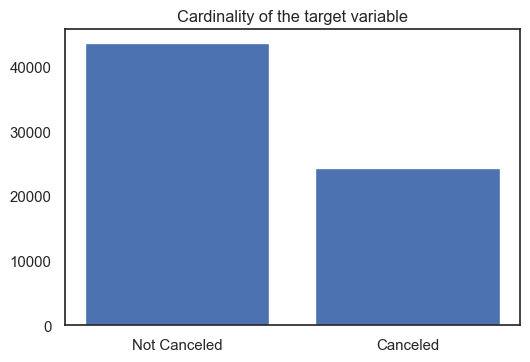

In [182]:
sns.set(style = "white")
plt.bar(height=data["IsCanceled"].value_counts(), x = ["Not Canceled", "Canceled"])
plt.title("Cardinality of the target variable")
plt.show()

In [183]:
def pairwise_relation(data, features = data.select_dtypes(include=np.number).set_index(data.index).columns,
 title = "Pairwise Relationship of Metric Variables", target = "IsCanceled"):
    
    # Pairwise Relationship of Numerical Variables
    sns.set(style='white')

    # Setting pairplot
    sns.pairplot(data[features], diag_kind="hist", hue=target)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title)

    plt.show()

In [184]:
#around 35 minutes or run time

# pairwise_relationship(data)

In [185]:
# sns.set(style='white')

# fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(32, 16))

# for ax, feat in zip(axes.flatten(), metric_features):
#     ax.hist(data[feat])
#     ax.set_title(feat, y=-0.11)
    
# title = "Metric Variables' Histograms"
# plt.suptitle(title)
# plt.show()

In [186]:
# Checking for consistency in high values for StaysInWeekNights
data.sort_values("StaysInWeekNights", ascending=False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
61734,0,140,2016,39,22,16,41,0,0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,K,12,No Deposit,9,NULL,0,Transient,8.34,0,2,Check-Out,2016-11-18,57,475.38,9,2016-09-22,3,18,46,11,4,1
47957,0,16,2016,11,11,14,35,0,0,0,BB,PRT,Corporate,TA/TO,0,0,0,A,K,21,No Deposit,NULL,215,0,Transient-Party,0.00,0,0,Check-Out,2016-04-29,49,0.00,3,2016-03-11,4,29,17,4,4,1
14644,0,206,2016,30,23,14,34,2,0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,K,6,No Deposit,9,NULL,0,Transient-Party,0.00,0,1,Check-Out,2016-09-09,48,0.00,7,2016-07-23,5,9,36,9,4,1
66501,0,11,2017,3,15,13,30,0,0,0,SC,USA,Online TA,TA/TO,0,0,0,A,K,14,No Deposit,9,NULL,0,Transient,0.00,0,0,Check-Out,2017-02-27,43,0.00,1,2017-01-15,6,27,9,2,0,1
63222,0,3,2016,47,14,9,25,2,0,0,BB,PRT,Corporate,Corporate,0,0,0,A,A,3,No Deposit,NULL,368,0,Transient,93.00,0,0,Check-Out,2016-12-18,34,3162.00,11,2016-11-14,0,18,50,12,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62752,0,0,2016,50,7,0,0,0,0,0,BB,PRT,Online TA,TA/TO,1,0,0,A,K,0,No Deposit,7,NULL,0,Transient,0.00,0,1,Check-Out,2016-12-07,0,0.00,12,2016-12-07,2,7,49,12,2,1
74645,0,8,2017,26,25,1,0,2,1,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,200.00,0,1,Check-Out,2017-06-26,1,200.00,6,2017-06-25,6,26,26,6,0,0
37448,0,0,2015,39,21,1,0,1,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,E,0,No Deposit,20,NULL,0,Transient,77.00,0,0,Check-Out,2015-09-22,1,77.00,9,2015-09-21,0,22,39,9,1,1
37449,0,5,2015,39,21,1,0,1,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,8,NULL,0,Transient,145.00,0,0,Check-Out,2015-09-22,1,145.00,9,2015-09-21,0,22,39,9,1,0


In [187]:
def boxplot (data, features = data.select_dtypes(include=np.number).set_index(data.index).columns):
    
    
    sns.set(style = 'white')
    fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 16))
    
    for ax, feat in zip(axes.flatten(), features): 

        sns.boxplot(data[feat], ax = ax)
        
    title = "Metric Variables' Boxplots"

    plt.suptitle(title)

    plt.show()

In [188]:
# boxplot(data, metric_features)

In [189]:
# to_plot = ['ArrivalDateMonthNumber', 'Meal','MarketSegment','DistributionChannel', 'ReservedRoomType', 'AssignedRoomType','DepositType', 'CustomerType', 'ReservationDayOfWeek', 'ArrivalDateYear', 'IsRepeatedGuest', 'ArrivalDateDayOfMonth', "ArrivalDayOfWeek","IsRoomChanged"]

# plot_cat_counts(data, to_plot)

<b> Categorical Features that show they might be important for the model: </b> IsRoomChanged, DepositType, IsRepeatedGuest, CustomerType, DistributionChannel, MarketSegment

In [190]:
# plot_histograms_boxplots(data, metric_features)

<b> Metric Features that show they might be important for the model: </b> LeadTime, TotalOfSpecialRequests

In [191]:
# for feature in metric_features:
#     g = sns.displot(data=data, x=feature, hue="IsCanceled", kind="kde");
#     g.fig.set_size_inches(10,5)

In [192]:
# sns.set(style='white')

# fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(32, 16))

# for ax, feat in zip(axes.flatten(), metric_features):
#     # sns.histplot(data[feat], ax=ax, hue = "IsCanceled")
#     sns.histplot(data=data, x=feat, hue="IsCanceled", ax = ax)
#     # ax.set_title(feat, y=-0.11)

# title = "Metric Variables' Histplots"
# plt.suptitle(title)
# plt.show()

In [193]:
# Trying to understand the average room economic value
data.groupby("ReservedRoomType")["ADR"].count()

ReservedRoomType
A                   51321
B                    1115
C                      14
D                   11704
E                    1551
F                    1791
G                     484
P                      10
Name: ADR, dtype: int64

In [194]:
data[(data["AssignedRoomType"] == "P               ")]
# data.ReservedRoomType.unique()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
20591,1,0,2016,47,17,4,11,0,0,0,SC,PRT,Corporate,Direct,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-11-17,15,0.0,11,2016-11-17,3,17,46,11,3,0
21184,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,0
21185,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,0
21189,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1,0
25847,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,0
25848,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,0
25849,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,0
25850,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0,0
32907,1,0,2017,32,11,0,0,0,0,0,SC,PRT,Online TA,TA/TO,0,0,0,P,P,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2017-08-11,0,0.0,8,2017-08-11,4,11,32,8,4,0
32908,1,0,2017,32,11,0,0,0,0,0,SC,PRT,Online TA,TA/TO,0,0,0,P,P,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2017-08-11,0,0.0,8,2017-08-11,4,11,32,8,4,0


In [195]:
#exploring records with ADR = 0
data.loc[data["ADR"] == 0]#.value_counts("ReservationStatus")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03,2,0.0,7,2015-07-01,2,3,27,7,4,0
134,1,0,2015,29,15,0,1,2,0,0,SC,PRT,Direct,Direct,0,0,0,A,F,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2015-07-15,1,0.0,7,2015-07-15,2,15,29,7,2,1
139,0,0,2015,29,15,2,5,2,0,0,SC,PRT,Direct,Direct,0,0,0,F,A,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-22,7,0.0,7,2015-07-15,2,22,30,7,2,1
166,0,18,2015,29,18,1,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-20,2,0.0,7,2015-07-18,5,20,30,7,0,0
196,0,12,2015,29,18,2,2,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-22,4,0.0,7,2015-07-18,5,22,30,7,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78571,0,78,2017,34,23,0,0,1,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,K,7,No Deposit,98,NULL,0,Transient-Party,0.0,0,0,Check-Out,2017-08-23,0,0.0,8,2017-08-23,2,23,34,8,2,1
78702,0,1,2017,34,24,0,1,2,1,0,BB,PRT,Complementary,Direct,0,0,0,A,D,1,No Deposit,NULL,NULL,0,Transient,0.0,0,3,Check-Out,2017-08-25,1,0.0,8,2017-08-24,3,25,34,8,4,1
78903,0,1,2017,35,27,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2017-08-27,0,0.0,8,2017-08-27,6,27,34,8,6,0
79042,0,518,2017,34,26,2,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,229,NULL,0,Transient-Party,0.0,0,0,Check-Out,2017-08-29,3,0.0,8,2017-08-26,5,29,35,8,1,0


In [196]:
#the same day different rooms have different ADRs
data.loc[(data["ArrivalDateYear"] == 2015) &
(data["ArrivalDateMonthNumber"] == 9) & 
(data["ArrivalDateDayOfMonth"] == 2)].sort_values("ADR")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged


In [197]:
# data.loc[(data["ADR"] == 0) & (data["MarketSegment"] != "Complementary")]
data.loc[(data["ADR"] == 0)].value_counts("MarketSegment")
# TODO: Visualization

MarketSegment
Complementary    508
Offline TA/TO    236
Online TA        173
Groups           122
Direct           111
Corporate         30
Aviation           6
dtype: int64

In [198]:
# Complementary also have non zero ADRs
data.loc[data["MarketSegment"] == "Complementary"].sort_values("ADR", ascending = False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
37755,0,0,2015,39,26,1,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,1,No Deposit,NULL,NULL,0,Transient,170.0,0,0,Check-Out,2015-09-28,2,340.0,9,2015-09-26,5,28,40,9,0,0
45705,0,0,2016,13,20,1,0,2,0,0,BB,DEU,Complementary,TA/TO,0,0,0,A,E,0,No Deposit,NULL,NULL,0,Transient,139.0,0,0,Check-Out,2016-03-21,1,139.0,3,2016-03-20,6,21,12,3,0,1
40489,1,8,2017,11,15,0,1,1,0,0,BB,PRT,Complementary,Direct,1,1,1,A,A,0,No Deposit,NULL,46,0,Transient,79.0,0,0,Canceled,2017-03-07,1,79.0,3,2017-03-15,2,7,10,3,1,0
40071,0,2,2015,46,9,1,2,1,0,0,BB,USA,Complementary,Direct,0,0,0,A,A,0,No Deposit,45,NULL,0,Group,79.0,0,0,Check-Out,2015-11-12,3,237.0,11,2015-11-09,0,12,46,11,3,0
61678,0,32,2016,47,15,0,2,2,0,0,BB,DEU,Complementary,Direct,0,0,0,E,E,0,No Deposit,NULL,NULL,0,Transient,75.0,0,1,Check-Out,2016-11-17,2,150.0,11,2016-11-15,1,17,46,11,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38583,1,1,2015,42,13,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,NULL,0,Transient,0.0,0,1,Canceled,2015-10-13,1,0.0,10,2015-10-13,1,13,42,10,1,0
38192,0,0,2016,17,21,0,1,1,0,0,BB,PRT,Complementary,Direct,1,0,1,G,G,0,No Deposit,NULL,45,0,Transient,0.0,0,0,Check-Out,2016-04-22,1,0.0,4,2016-04-21,3,22,16,4,4,0
38191,0,8,2015,41,6,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,45,0,Transient,0.0,0,0,Check-Out,2015-10-07,1,0.0,10,2015-10-06,1,7,41,10,2,0
38149,1,8,2015,41,6,0,1,1,0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,45,0,Transient,0.0,0,0,No-Show,2015-10-06,1,0.0,10,2015-10-06,1,6,41,10,1,0


In [199]:
data.value_counts("MarketSegment")

MarketSegment
Online TA        38748
Offline TA/TO    16747
Direct            6093
Corporate         2986
Groups            2635
Complementary      542
Aviation           237
Undefined            2
dtype: int64

In [200]:
# #TODO using pairwise relationship choose the correct correlation method (spearman vs pearsons)

# def cor_heatmap(cor):
#     plt.figure(figsize=(20,20))
#     sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
#     plt.show()
    
# cor_heatmap(np.round(data[metric_features].corr(),3))

## SCALING

In [201]:
data_scal = data.copy()

In [202]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(data[metric_features])
scaled_feat

array([[-0.91485232, -0.00864585, -0.91323822, ..., -0.77409108,
        -0.53729489, -1.31992956],
       [-0.0534461 , -0.00864585, -0.91323822, ...,  0.46133655,
         0.48273051, -0.11312729],
       [-0.29506004, -0.00864585, -0.91323822, ...,  0.46133655,
         0.48273051, -0.24721643],
       ...,
       [-0.62071361,  0.58459872,  1.31448375, ...,  4.16761947,
         2.0127686 ,  3.0339054 ],
       [ 0.16715794,  0.58459872,  1.31448375, ..., -0.77409108,
         2.0127686 ,  1.56219821],
       [ 1.17563351,  0.58459872,  1.31448375, ...,  1.69676419,
         3.032794  ,  4.04679111]])

In [203]:
data_scal[metric_features] = scaled_feat
data_scal.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,-0.914852,2015,-0.008646,1,-0.913238,-0.153034,-1.611830,-0.266523,-0.063318,HB,PRT,Offline TA/TO,TA/TO,0,-0.136863,-0.083761,A,A,-0.32621,No Deposit,6,NULL,-0.147148,Transient,-2.433802,-0.170204,-0.774091,Check-Out,2015-07-03,-0.537295,-1.319930,7,2015-07-01,2,3,27,7,4,0
1,1,-0.053446,2015,-0.008646,1,-0.913238,1.157144,0.278928,-0.266523,-0.063318,BB,PRT,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,-0.32621,No Deposit,9,NULL,-0.147148,Transient,-0.720917,-0.170204,0.461337,Canceled,2015-07-01,0.482731,-0.113127,7,2015-07-01,2,1,27,7,2,0
2,1,-0.295060,2015,-0.008646,1,-0.913238,1.157144,-1.611830,-0.266523,-0.063318,BB,PRT,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,-0.32621,No Deposit,9,NULL,-0.147148,Transient,-0.911238,-0.170204,0.461337,Canceled,2015-04-30,0.482731,-0.247216,7,2015-07-01,2,30,18,4,3,0
3,1,-0.011426,2015,-0.008646,1,1.314484,1.157144,0.278928,-0.266523,-0.063318,BB,PRT,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,-0.32621,No Deposit,9,NULL,-0.147148,Transient,-0.720917,-0.170204,1.696764,Canceled,2015-06-23,1.502756,0.490274,7,2015-07-01,2,23,26,6,1,0
4,1,0.072613,2015,-0.008646,2,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,BB,PRT,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,-0.32621,No Deposit,9,NULL,-0.147148,Transient,-0.720917,-0.170204,0.461337,Canceled,2015-04-02,-0.537295,-0.716528,7,2015-07-02,3,2,14,4,3,0


In [204]:
df = data_scal.copy()

## OUTLIERS TREATEMENT

In [205]:
data_out = df.copy()

In [206]:
# One Class Support Vector Machine
ee = OneClassSVM(nu=0.02)
yhat = ee.fit_predict(data_out[metric_features])
# yhat1 = ee.fit_predict(data_out[numeric_features])

In [207]:
data_out['Outliers'] = yhat
# data_out1['Outliers'] = yhat1
data_out_rem= data_out[data_out['Outliers']==1]
# data_out_rem1= data_out1[data_out1['Outliers']==1]

In [208]:
#TODO check records marked as outliers and check if they can be considered outliers
data_out[data_out["Outliers"] == -1]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged,Outliers
54,1,-0.032436,2015,0.065510,7,4.656067,8.363122,-1.611830,-0.266523,-0.063318,SC,PRT,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,-0.326210,No Deposit,11,NULL,-0.147148,Transient,-1.345616,-0.170204,-0.774091,Canceled,2015-04-08,8.642934,2.513442,7,2015-07-07,1,8,15,4,2,0,-1
55,1,-0.032436,2015,0.065510,7,4.656067,8.363122,-1.611830,-0.266523,-0.063318,SC,PRT,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,-0.326210,No Deposit,11,NULL,-0.147148,Transient,-1.345616,-0.170204,-0.774091,Canceled,2015-04-11,8.642934,2.513442,7,2015-07-07,1,11,15,4,5,0,-1
56,1,0.251198,2015,0.065510,7,4.656067,8.363122,-1.611830,-0.266523,-0.063318,BB,PRT,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,-0.326210,No Deposit,11,NULL,-0.147148,Transient,-1.345616,-0.170204,-0.774091,Canceled,2015-04-08,8.642934,2.513442,7,2015-07-07,1,8,15,4,2,0,-1
139,0,-0.977882,2015,0.139665,15,1.314484,1.812233,0.278928,-0.266523,-0.063318,SC,PRT,Direct,Direct,0,-0.136863,-0.083761,F,A,5.845778,No Deposit,NULL,NULL,-0.147148,Transient,-2.433802,-0.170204,-0.774091,Check-Out,2015-07-22,2.012769,-1.319930,7,2015-07-15,2,22,30,7,2,1,-1
265,0,-0.767783,2015,0.213821,22,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,BB,PRT,Groups,TA/TO,0,-0.136863,-0.083761,A,A,10.474770,No Deposit,1,NULL,-0.147148,Transient,-1.045581,-0.170204,-0.774091,Check-Out,2015-07-24,-0.537295,-0.830899,7,2015-07-22,2,24,30,7,4,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79101,0,1.175634,2017,0.584599,29,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,SC,DEU,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,-0.326210,No Deposit,9,NULL,-0.147148,Transient,-0.217127,-0.170204,5.403047,Check-Out,2017-08-31,-0.537295,-0.539058,8,2017-08-29,1,31,35,8,3,0,-1
79107,0,1.459267,2017,0.510443,26,1.314484,0.502055,0.278928,-0.266523,-0.063318,BB,ITA,Online TA,TA/TO,0,-0.136863,-0.083761,A,A,10.474770,No Deposit,9,NULL,-0.147148,Transient,0.230686,-0.170204,-0.774091,Check-Out,2017-08-31,0.992743,1.026630,8,2017-08-26,5,31,35,8,3,0,-1
79208,0,1.259673,2017,0.584599,28,0.200623,0.502055,-1.611830,-0.266523,-0.063318,HB,PRT,Groups,TA/TO,0,-0.136863,-0.083761,A,A,15.103762,No Deposit,19,NULL,-0.147148,Transient-Party,-0.065990,-0.170204,0.461337,Check-Out,2017-09-01,0.482731,0.348297,8,2017-08-28,0,1,35,9,4,0,-1
79274,0,2.436228,2017,0.584599,30,-0.913238,1.157144,0.278928,-0.266523,-0.063318,BB,GBR,Online TA,TA/TO,0,-0.136863,-0.083761,D,D,-0.326210,No Deposit,9,NULL,-0.147148,Transient,0.458623,-0.170204,4.167619,Check-Out,2017-09-03,0.482731,0.717910,8,2017-08-30,2,3,35,9,6,0,-1


In [209]:
# print("Percentage kept: " , len(data_out_rem) / len(data_out))
# boxplot(data_out_rem, metric_features)

In [210]:
# plot_histograms_boxplots(data_out_rem, metric_features)

In [211]:
# plot_cat_counts(data_out_rem, to_plot)

In [212]:
# For lower cardinalities, we create a Others category

In [213]:
data_out_rem["DistributionChannel"].replace(["GDS", "Undefined"], "Others", inplace=True)
data_out_rem['DistributionChannel'].value_counts()

TA/TO        56933
Direct        6306
Corporate     3103
Others         196
Name: DistributionChannel, dtype: int64

In [214]:
data_out_rem['MarketSegment'].replace(["Aviation", "Undefined", "Complementary"], "Others", inplace=True)
data_out_rem['MarketSegment'].value_counts()

Online TA        38192
Offline TA/TO    16513
Direct            5853
Corporate         2784
Groups            2536
Others             660
Name: MarketSegment, dtype: int64

In [215]:
data_out_rem['ReservedRoomType'].replace(["G               ", "C               ", "P               "], "Others", inplace=True)
data_out_rem['ReservedRoomType'].value_counts()

A                   50503
D                   11513
F                    1650
E                    1446
B                    1038
Others                388
Name: ReservedRoomType, dtype: int64

In [216]:
data_out_rem['AssignedRoomType'].replace(["G               ", "C               ", "P               ", "K               "], "Others", inplace=True)
data_out_rem['AssignedRoomType'].value_counts()

A                   45408
D                   14401
E                    2053
F                    1875
B                    1849
Others                952
Name: AssignedRoomType, dtype: int64

In [217]:
#plot_cat_counts(data_out_rem, to_plot)


In [218]:
print("Percentage of data kept after outlier removal:", np.round((len(data_out_rem) / len(data)*100), 6), "%")

Percentage of data kept after outlier removal: 97.864392 %


In [219]:
data_out_rem.drop("Outliers", axis = 1, inplace = True)
df = data_out_rem.copy()

## ENCODING

In [220]:
data_ohc = df.copy()

In [221]:
categorical_features

['Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'Company',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDateMonthNumber',
 'ArrivalDate',
 'ArrivalDayOfWeek',
 'ReservationDayOfMonth',
 'ReservationWeekOfYear',
 'ReservationMonth',
 'ReservationDayOfWeek',
 'ArrivalDateYear',
 'ArrivalDateDayOfMonth',
 'IsRepeatedGuest',
 'IsCanceled',
 'IsRoomChanged']

In [222]:
#TODO discuss it --> is it worthy ? some models do not need it (ex DT)
#List of features to be encoded using one hot encoder
#IsRoomChanged, DepositType, IsRepeatedGuest, CustomerType, DistributionChannel, MarketSegment
to_encode = ['Meal', 'MarketSegment', 'DistributionChannel', 'DepositType', 'CustomerType', "ReservationDayOfWeek"]

In [223]:
ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df[to_encode])
ohc_feat_names = ohc.get_feature_names(input_features=to_encode)
ohc_df = pd.DataFrame(ohc_feat, index=df.index, columns=ohc_feat_names)

ohc_df

,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,ReservationDayOfWeek_0,ReservationDayOfWeek_1,ReservationDayOfWeek_2,ReservationDayOfWeek_3,ReservationDayOfWeek_4,ReservationDayOfWeek_5,ReservationDayOfWeek_6
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
79326,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
79327,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
79328,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [224]:
df_ohc = pd.concat([data_ohc.drop(columns=categorical_features), ohc_df, data_ohc[["IsCanceled", "ReservationStatusDate"]]], axis=1)
df_ohc

,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_Offline TA/TO,MarketSegment_Online TA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_No Deposit,DepositType_Non Refund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,ReservationDayOfWeek_0,ReservationDayOfWeek_1,ReservationDayOfWeek_2,ReservationDayOfWeek_3,ReservationDayOfWeek_4,ReservationDayOfWeek_5,ReservationDayOfWeek_6,IsCanceled,ReservationStatusDate
0,-0.914852,-0.008646,-0.913238,-0.153034,-1.611830,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-2.433802,-0.170204,-0.774091,-0.537295,-1.319930,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2015-07-03
1,-0.053446,-0.008646,-0.913238,1.157144,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,0.461337,0.482731,-0.113127,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,2015-07-01
2,-0.295060,-0.008646,-0.913238,1.157144,-1.611830,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.911238,-0.170204,0.461337,0.482731,-0.247216,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2015-04-30
3,-0.011426,-0.008646,1.314484,1.157144,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,1.696764,1.502756,0.490274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,2015-06-23
4,0.072613,-0.008646,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,0.461337,-0.537295,-0.716528,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,-0.736268,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.281165,-0.170204,-0.774091,2.012769,1.334168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,2017-09-06
79326,0.093623,0.584599,1.314484,1.812233,2.169686,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,2.613723,-0.170204,1.696764,2.012769,4.903424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2017-09-07
79327,-0.620714,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,1.097428,-0.170204,4.167619,2.012769,3.033905,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2017-09-07
79328,0.167158,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.096218,-0.170204,-0.774091,2.012769,1.562198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2017-09-07


In [225]:
#TO AVOID ENCODING COMMENT THIS WHOLE CELL

#Adding encoded features to metric and removing from categorical
for feat in to_encode:
    categorical_features.remove(feat)

encoded_feat = []

#Taking out empty spaces for columns names
for feat in ohc_df.columns:
    feat2 = feat.replace(" ", "")
    encoded_feat.append(feat2)
    df_ohc.rename(columns = {feat:feat2}, inplace = True)

metric_features.extend(encoded_feat)

df = df_ohc.copy()

In [226]:
df

,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_OfflineTA/TO,MarketSegment_OnlineTA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_NoDeposit,DepositType_NonRefund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,ReservationDayOfWeek_0,ReservationDayOfWeek_1,ReservationDayOfWeek_2,ReservationDayOfWeek_3,ReservationDayOfWeek_4,ReservationDayOfWeek_5,ReservationDayOfWeek_6,IsCanceled,ReservationStatusDate
0,-0.914852,-0.008646,-0.913238,-0.153034,-1.611830,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-2.433802,-0.170204,-0.774091,-0.537295,-1.319930,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2015-07-03
1,-0.053446,-0.008646,-0.913238,1.157144,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,0.461337,0.482731,-0.113127,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,2015-07-01
2,-0.295060,-0.008646,-0.913238,1.157144,-1.611830,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.911238,-0.170204,0.461337,0.482731,-0.247216,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2015-04-30
3,-0.011426,-0.008646,1.314484,1.157144,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,1.696764,1.502756,0.490274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,2015-06-23
4,0.072613,-0.008646,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,0.461337,-0.537295,-0.716528,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,-0.736268,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.281165,-0.170204,-0.774091,2.012769,1.334168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,2017-09-06
79326,0.093623,0.584599,1.314484,1.812233,2.169686,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,2.613723,-0.170204,1.696764,2.012769,4.903424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2017-09-07
79327,-0.620714,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,1.097428,-0.170204,4.167619,2.012769,3.033905,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2017-09-07
79328,0.167158,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.096218,-0.170204,-0.774091,2.012769,1.562198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,2017-09-07


# Feature Selection

In [390]:
df_train = df.copy()
df_train.drop("IsCanceled", axis = 1, inplace = True)
df_train.drop("ReservationStatusDate", axis = 1, inplace = True)
target = df["IsCanceled"]
reservation_date = df["ReservationStatusDate"]

### RFE Regression

In [228]:
# ## This is running forever. Code needs to be modified.

# nof_list=np.arange(1,15)            
# high_score=0
# #Variable to store the optimum features
# nof=0           
# score_list =[]
# for n in range(len(nof_list)):
#     model = RandomForestRegressor()
#     rfe = RFE(estimator = model, n_features_to_select = nof_list[n])
#     x_train_rfe = rfe.fit_transform(df_train, target)
#     x_train_rfe = rfe.transform(df_train)
#     model.fit(x_train_rfe, df['IsCanceled'])
    
#     score = model.score(x_train_rfe, df['IsCanceled'])
#     score_list.append(score)
    
#     if(score>high_score):
#         high_score = score
#         nof = nof_list[n]
# print("Optimum number of features: %d" %nof)
# print("Score with %d features: %f" % (nof, high_score))
# nof_list

In [229]:
# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor()
# rfe = RFE(estimator = model, n_features_to_select = nof)
# x_rfe = rfe.fit_transform(X = df_train, y = target)
# print(rfe.support_)
# print(rfe.ranking_)
# selected_features = pd.Series(rfe.support_, index = df.columns)
# selected_features

### Lasso

In [230]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    fig,ax=plt.subplots(figsize=(7,4))
    imp_coef.plot(kind = "barh", ax=ax)
    title = "Feature importance using " + name + " Model"
    plt.title(title)
    if save_plots:
            save_fig(title, fig)        
    plt.show()

Lasso picked 16 variables and eliminated the other 28 variables


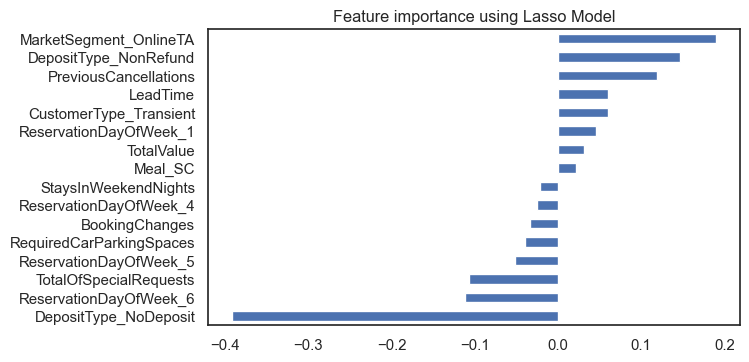

LeadTime                    0.060408
StaysInWeekendNights       -0.021129
PreviousCancellations       0.119082
BookingChanges             -0.033480
RequiredCarParkingSpaces   -0.039752
TotalOfSpecialRequests     -0.107136
TotalValue                  0.031043
Meal_SC                     0.021511
MarketSegment_OnlineTA      0.189464
DepositType_NoDeposit      -0.391349
DepositType_NonRefund       0.146044
CustomerType_Transient      0.059511
ReservationDayOfWeek_1      0.045694
ReservationDayOfWeek_4     -0.024972
ReservationDayOfWeek_5     -0.051816
ReservationDayOfWeek_6     -0.112375
dtype: float64

In [231]:
threshold = 0.02 
reg = LassoCV()
reg.fit(df_train, target)
coef = pd.Series(reg.coef_, index = df_train.columns)
# print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
print("Lasso picked " + str(sum(abs(coef)>threshold)) + " variables and eliminated the other " +  str(sum(abs(coef)<=threshold)) + " variables")
coef.sort_values()
# plot_importance(coef[coef!=0],'Lasso')
plot_importance(coef[abs(coef)>threshold],'Lasso')
bf_lasso = coef[abs(coef)>threshold].index
coef[abs(coef)>threshold]

In [232]:
bf_lasso.tolist()

['LeadTime',
 'StaysInWeekendNights',
 'PreviousCancellations',
 'BookingChanges',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'TotalValue',
 'Meal_SC',
 'MarketSegment_OnlineTA',
 'DepositType_NoDeposit',
 'DepositType_NonRefund',
 'CustomerType_Transient',
 'ReservationDayOfWeek_1',
 'ReservationDayOfWeek_4',
 'ReservationDayOfWeek_5',
 'ReservationDayOfWeek_6']

### Mutual info classifier

In [233]:
class UnivariateFeatureSelction:
    def __init__(self, n_features, problem_type, scoring, return_cols=True):
        """
        Custom univariate feature selection wrapper on
        different univariate feature selection models from
        scikit-learn.
        :param n_features: SelectPercentile if float else SelectKBest
        :param problem_type: classification or regression
        :param scoring: scoring function, string
        """

        self.n_features = n_features
        
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
            
        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring],
                k=n_features
            )
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(valid_scoring[scoring], percentile=int(n_features * 100))
        else:
            raise Exception("Invalid type of feature")
    
    def fit(self, X, y):
        return self.selection.fit(X, y)
    
    def transform(self, X):
        return self.selection.transform(X)
    
    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)
    
    def return_cols(self, X):
        if isinstance(self.n_features, int):
            mask = SelectKBest.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
                    
        elif isinstance(self.n_features, float):
            mask = SelectPercentile.get_support(self.selection)
            selected_features = []
            features = list(X.columns)
            for bool, feature in zip(mask, features):
                if bool:
                    selected_features.append(feature)
        else:
            raise Exception("Invalid type of feature")
        
        return selected_features

In [234]:
ufs = UnivariateFeatureSelction(
    n_features=0.3,
    problem_type="classification",
    scoring="mutual_info_classif"
)

ufs.fit(df_train, target.values.ravel())
bf_mic = ufs.return_cols(df_train)

In [235]:
print(len(bf_mic))
bf_mic

13


['LeadTime',
 'PreviousCancellations',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'TotalValue',
 'DistributionChannel_TA/TO',
 'DepositType_NoDeposit',
 'DepositType_NonRefund',
 'CustomerType_Transient',
 'CustomerType_Transient-Party']

### Fisher

In [236]:
# GIVES ME A MEMORY ERROR
# ranks = fisher_score.fisher_score(df_train, target)

In [237]:
# feat_importances = pd.Series(ranks, df_train.columns[0:len(df_train.columns)-1])
# feat_importances.plot(kind = "barh")
# plt.show()

### Random Forest Classifier

In [238]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=len(df_train.columns))
embeded_rf_selector.fit(df_train, target)

SelectFromModel(estimator=RandomForestClassifier(), max_features=44)

In [239]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = df_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
embeded_rf_feature

11 selected features


['LeadTime',
 'ArrivalDateWeekNumber',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'PreviousCancellations',
 'ADR',
 'TotalOfSpecialRequests',
 'DurationOfStay',
 'TotalValue',
 'DepositType_NoDeposit',
 'DepositType_NonRefund']

### Correlation

In [240]:
#saving in metric_features2 metric features without any encoded features

metric_features2 = metric_features.copy()
for feat in metric_features:
    if len(df_train[feat].unique()) == 2:
        metric_features2.remove(feat)

In [241]:
# pairwise_relation(df_train, metric_features2, target = None)

In [242]:
# img = Image.open('pairwise relationship.png')
# img.show()

In [243]:
#by looking at the pairwise relationship we decided to use sperman correlation 
# (default)
# cor_heatmap(np.round(df_train[metric_features2].corr(method = "spearman"),3))

In [244]:
bf_corr = metric_features2.copy()
bf_corr.remove("TotalValue")
bf_corr.remove("DurationOfStay")

# Model 

In [391]:
# possible values: bf_mic, embeded_rf_feature, bf_lasso.tolist(), bf_corr
subset = bf_lasso.tolist()

df_train = pd.concat([df_train, reservation_date], axis = 1)
df_train


,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_OfflineTA/TO,MarketSegment_OnlineTA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_NoDeposit,DepositType_NonRefund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,ReservationDayOfWeek_0,ReservationDayOfWeek_1,ReservationDayOfWeek_2,ReservationDayOfWeek_3,ReservationDayOfWeek_4,ReservationDayOfWeek_5,ReservationDayOfWeek_6,ReservationStatusDate
0,-0.914852,-0.008646,-0.913238,-0.153034,-1.611830,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-2.433802,-0.170204,-0.774091,-0.537295,-1.319930,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015-07-03
1,-0.053446,-0.008646,-0.913238,1.157144,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,0.461337,0.482731,-0.113127,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2015-07-01
2,-0.295060,-0.008646,-0.913238,1.157144,-1.611830,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.911238,-0.170204,0.461337,0.482731,-0.247216,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2015-04-30
3,-0.011426,-0.008646,1.314484,1.157144,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,1.696764,1.502756,0.490274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2015-06-23
4,0.072613,-0.008646,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.720917,-0.170204,0.461337,-0.537295,-0.716528,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,-0.736268,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.281165,-0.170204,-0.774091,2.012769,1.334168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-09-06
79326,0.093623,0.584599,1.314484,1.812233,2.169686,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,2.613723,-0.170204,1.696764,2.012769,4.903424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-09-07
79327,-0.620714,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,1.097428,-0.170204,4.167619,2.012769,3.033905,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-09-07
79328,0.167158,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.096218,-0.170204,-0.774091,2.012769,1.562198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-09-07


In [392]:
#using time series split to cross validate the training data, and splitting based on reservation status date

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
skf = StratifiedKFold(n_splits=10, shuffle=False)

In [393]:
# df_index = pd.concat([df_train, target, reservation_date], axis = 1)
df_index = pd.concat([df_train, target], axis = 1)
# df_index = pd.concat([df_train, target, reservation_date], axis = 1)
df_index.sort_values("ReservationStatusDate", inplace = True)
df_index.reset_index(inplace = True, drop = False)
df_index

,index,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_OfflineTA/TO,MarketSegment_OnlineTA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_NoDeposit,DepositType_NonRefund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,ReservationDayOfWeek_0,ReservationDayOfWeek_1,ReservationDayOfWeek_2,ReservationDayOfWeek_3,ReservationDayOfWeek_4,ReservationDayOfWeek_5,ReservationDayOfWeek_6,ReservationStatusDate,IsCanceled
0,33655,1.732396,-0.008646,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17,1
1,33816,2.394208,0.658754,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17,1
2,33794,2.320673,0.584599,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17,1
3,33774,2.247139,0.510443,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17,1
4,33675,1.805931,0.065510,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66533,79325,-0.736268,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.281165,-0.170204,-0.774091,2.012769,1.334168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2017-09-06,0
66534,79328,0.167158,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.096218,-0.170204,-0.774091,2.012769,1.562198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-09-07,0
66535,79326,0.093623,0.584599,1.314484,1.812233,2.169686,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,2.613723,-0.170204,1.696764,2.012769,4.903424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-09-07,0
66536,79327,-0.620714,0.584599,1.314484,1.812233,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,1.097428,-0.170204,4.167619,2.012769,3.033905,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-09-07,0


In [394]:
target = df_index["IsCanceled"]
df_train = df_index.drop("IsCanceled", axis = 1)
# df_train = df_index.drop("ReservationStatusDate", axis = 1)

# df_train = df_train[subset]

In [395]:
target.value_counts()

0    42647
1    23891
Name: IsCanceled, dtype: int64

In [396]:
# X_train, X_test, y_train, y_test = train_test_split(df_train[subset], target, test_size=0.3, random_state=5, stratify=target)

# Shuffle = False so we keep the datetime order --> train data is past data used to predict the future (test)
X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.3, random_state=5, shuffle = False)

In [397]:
X_train

,index,LeadTime,ArrivalDateWeekNumber,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue,Meal_BB,Meal_FB,Meal_HB,Meal_SC,MarketSegment_Corporate,MarketSegment_Direct,MarketSegment_Groups,MarketSegment_OfflineTA/TO,MarketSegment_OnlineTA,MarketSegment_Others,DistributionChannel_Corporate,DistributionChannel_Direct,DistributionChannel_Others,DistributionChannel_TA/TO,DepositType_NoDeposit,DepositType_NonRefund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,ReservationDayOfWeek_0,ReservationDayOfWeek_1,ReservationDayOfWeek_2,ReservationDayOfWeek_3,ReservationDayOfWeek_4,ReservationDayOfWeek_5,ReservationDayOfWeek_6,ReservationStatusDate
0,33655,1.732396,-0.008646,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17
1,33816,2.394208,0.658754,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17
2,33794,2.320673,0.584599,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17
3,33774,2.247139,0.510443,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17
4,33675,1.805931,0.065510,-0.913238,-0.153034,0.278928,-0.266523,-0.063318,2.517999,-0.083761,-0.32621,-0.147148,-1.027669,-0.170204,-0.774091,-0.537295,-0.824588,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46571,64566,-0.620714,-1.788380,-0.913238,-0.808123,-1.611830,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.754503,-0.170204,-0.774091,-1.047308,-1.024145,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-01-19
46572,29209,0.387762,-0.379424,1.314484,0.502055,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.438795,-0.170204,-0.774091,0.992743,0.437033,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-01-19
46573,64525,-0.515664,-1.862535,1.314484,0.502055,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.264148,-0.170204,-0.774091,0.992743,0.590841,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-01-19
46574,64567,-0.820308,-1.788380,0.200623,-0.153034,0.278928,-0.266523,-0.063318,-0.136863,-0.083761,-0.32621,-0.147148,-0.381251,-0.170204,-0.774091,-0.027282,-0.235346,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2017-01-19


In [398]:
y_train.value_counts()

0    28682
1    17894
Name: IsCanceled, dtype: int64

In [399]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks


# # resampling the target variable so that is not imbalanced anymore

# OVER SAMPLING

smote = SMOTE(sampling_strategy=1)
X_train, y_train = smote.fit_resample(X_train[subset+["index"]], y_train)

In [400]:
X_train

,LeadTime,StaysInWeekendNights,PreviousCancellations,BookingChanges,RequiredCarParkingSpaces,TotalOfSpecialRequests,TotalValue,Meal_SC,MarketSegment_OnlineTA,DepositType_NoDeposit,DepositType_NonRefund,CustomerType_Transient,ReservationDayOfWeek_1,ReservationDayOfWeek_4,ReservationDayOfWeek_5,ReservationDayOfWeek_6,index
0,1.732396,-0.913238,2.517999,-0.32621,-0.170204,-0.774091,-0.824588,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,33655
1,2.394208,-0.913238,2.517999,-0.32621,-0.170204,-0.774091,-0.824588,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,33816
2,2.320673,-0.913238,2.517999,-0.32621,-0.170204,-0.774091,-0.824588,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,33794
3,2.247139,-0.913238,2.517999,-0.32621,-0.170204,-0.774091,-0.824588,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,33774
4,1.805931,-0.913238,2.517999,-0.32621,-0.170204,-0.774091,-0.824588,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,33675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57359,0.290781,-0.913238,-0.136863,-0.32621,-0.170204,0.461337,-0.218950,0.582227,1.000000,1.0,0.0,1.000000,0.582227,0.417773,0.0,0.0,17973
57360,0.881495,1.314484,2.517999,-0.32621,-0.170204,-0.774091,-0.365530,0.000000,0.000000,0.0,1.0,1.000000,0.000000,0.000000,0.0,0.0,42866
57361,0.267180,-0.913238,-0.136863,-0.32621,-0.170204,-0.774091,-0.722178,0.000000,0.698301,1.0,0.0,1.000000,0.301699,0.000000,0.0,0.0,11486
57362,-0.154500,-0.564731,-0.136863,-0.32621,-0.170204,0.923677,-0.065323,0.000000,0.687118,1.0,0.0,0.687118,0.000000,0.000000,0.0,0.0,9480


In [401]:
y_train.value_counts()

1    28682
0    28682
Name: IsCanceled, dtype: int64

<AxesSubplot:>

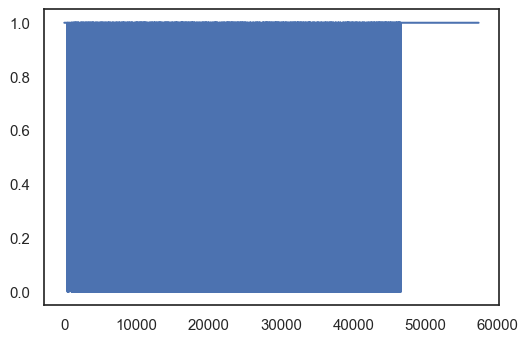

In [402]:
y_train.plot()

In [388]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(sampling_strategy = 1, random_state = 123)
# X_train, y_train = rus.fit_resample(X_train[subset+["index"]], y_train)
# y_train.value_counts()

0    22945
1    22945
Name: IsCanceled, dtype: int64

In [349]:
# temp = pd.concat([X_train, y_train], axis = 1, join = "inner")
# # temp = X_train.copy()
# temp.sort_values("index", inplace = True)
# temp.reset_index(drop = True, inplace = True)
# # temp.drop("index", axis = 1, inplace = True)
# y_train = temp["IsCanceled"].copy()
# X_train = temp.drop("IsCanceled", axis = 1)
# # X_train = temp.drop("ReservationStatusDate", axis = 1)

In [403]:
y_test.value_counts()

0    13965
1     5997
Name: IsCanceled, dtype: int64

In [404]:
smote = SMOTE(sampling_strategy=1)
X_test, y_test = smote.fit_resample(X_test[subset+["index"]], y_test)
y_test.value_counts()

1    13965
0    13965
Name: IsCanceled, dtype: int64

In [405]:
y_test.value_counts()

1    13965
0    13965
Name: IsCanceled, dtype: int64

In [365]:
# temp = pd.concat([X_test, y_test], axis = 1, join = "inner")
# # temp = X_train.copy()
# temp.sort_values("index", inplace = True)
# temp.reset_index(drop = True, inplace = True)
# # temp.drop("index", axis = 1, inplace = True)
# y_test = temp["IsCanceled"].copy()
# X_test = temp.drop("IsCanceled", axis = 1)
# # X_train = temp.drop("ReservationStatusDate", axis = 1)

true positive : cancellation is predicted correctly <p>
false positive : non-cancellation are predicted to be cancellations --> OVERBOOKING --> more costly for the hotel<p>
true negative : non-cancellation is predicted correctly <p>
false negative : cancellation are predicted to be non-cancellations --> EMPTY ROOMS --> if too high rooms are empty, opportunity cost

### Logistic Regression

In [118]:
# lr = LogisticRegression()

# i=1
# lr_f1beta = []
# lr_precision = []
# lr_recall = []
# lr_accuracy = []

# for train_index, test_index in skf.split(X_train[subset], y_train):

#     xtr,xvl = X_train.iloc[train_index][subset], X_train.iloc[test_index][subset]
#     ytr,yvl = y_train.iloc[train_index], y_train.iloc[test_index]

#     lr.fit(xtr,ytr)
#     y_pred = lr.predict(xvl)
#     lr_f1beta.append(fbeta_score(yvl, y_pred, beta = 1.5))
#     lr_precision.append(precision_score(yvl, y_pred))
#     lr_recall.append(recall_score(yvl, y_pred))
#     lr_accuracy.append(accuracy_score(yvl, y_pred))

# scores_lr = pd.DataFrame(data = {"Beta F1" : lr_f1beta,
#     "Precision" : lr_precision,
#     "Recall" : lr_recall, 
#     "Accuracy" : lr_accuracy
#     }, 
#     index = range(1, skf.n_splits + 1) 
# )
# scores_lr.sort_values("Beta F1", ascending = False)

In [119]:
# cm = confusion_matrix(y_test, lr.predict(X_test[subset]))
# cm

In [120]:
# cr = classification_report(y_test, lr.predict(X_test[subset]))
# print(cr)

In [407]:
lr = LogisticRegression()

i=1
lr_f1beta = []
lr_precision = []
lr_recall = []
lr_accuracy = []

for train_index, test_index in tscv.split(X_train):

    xtr,xvl = X_train.iloc[train_index][subset], X_train.iloc[test_index][subset]
    ytr,yvl = y_train.iloc[train_index], y_train.iloc[test_index]

    lr.fit(xtr,ytr)
    y_pred = lr.predict(xvl)
    lr_f1beta.append(fbeta_score(yvl, y_pred, beta = 1.5))
    lr_precision.append(precision_score(yvl, y_pred))
    lr_recall.append(recall_score(yvl, y_pred))
    lr_accuracy.append(accuracy_score(yvl, y_pred))

scores_lr = pd.DataFrame(data = {"Beta F1" : lr_f1beta,
    "Precision" : lr_precision,
    "Recall" : lr_recall, 
    "Accuracy" : lr_accuracy
    }, 
    index = range(1, tscv.n_splits + 1) 
)
scores_lr.sort_values("Beta F1", ascending = False)

,Beta F1,Precision,Recall,Accuracy
5,0.723619,1.000000,0.644456,0.644456
2,0.685350,0.661690,0.696417,0.780439
4,0.607071,0.864733,0.536078,0.735565
1,0.516530,0.990939,0.425907,0.705021
3,0.514650,0.558511,0.497294,0.723013


In [408]:
cm = confusion_matrix(y_test, lr.predict(X_test[subset]))
cm

array([[10908,  3057],
       [ 5485,  8480]], dtype=int64)

In [409]:
cr = classification_report(y_test, lr.predict(X_test[subset]))
print(cr)

              precision    recall  f1-score   support

           0       0.67      0.78      0.72     13965
           1       0.74      0.61      0.67     13965

    accuracy                           0.69     27930
   macro avg       0.70      0.69      0.69     27930
weighted avg       0.70      0.69      0.69     27930



### Decision Trees

In [413]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
# dt = DecisionTreeClassifier()

# dt_params = {
#     'splitter':['random'],
#     'criterion':['gini','entropy'],
#     'min_samples_split':[1,2,3,4,5,6],
#     'max_depth': [7,8,9,10,11,12,13],
#     'min_samples_leaf':[1,2,3,4,5,6]
# }

# gsdt = GridSearchCV(dt, dt_params, scoring='recall')
# gsdt.fit(X_train[subset], y_train)

# sorted(gsdt.cv_results_.keys())
# print(gsdt.best_score_, gsdt.best_params_)

In [ ]:
# i=1
# dt_f1beta = []
# dt_precision = []
# dt_recall = []
# dt_accuracy = []

# dt = DecisionTreeClassifier(criterion='gini',max_depth=7,min_samples_leaf=2,min_samples_split=5,splitter='random')

# for train_index, test_index in skf.split(X_train[subset], y_train):

#     xtr,xvl = X_train.iloc[train_index][subset], X_train.iloc[test_index][subset]
#     ytr,yvl = y_train.iloc[train_index], y_train.iloc[test_index]

#     dt.fit(xtr,ytr)
#     y_pred = dt.predict(xvl)
#     dt_f1beta.append(fbeta_score(yvl, y_pred, beta = 1.5))
#     dt_precision.append(precision_score(yvl, y_pred))
#     dt_recall.append(recall_score(yvl, y_pred))
#     dt_accuracy.append(accuracy_score(yvl, y_pred))

# scores_dt = pd.DataFrame(data = {"Beta F1" : dt_f1beta,
#     "Precision" : dt_precision,
#     "Recall" : dt_recall, 
#     "Accuracy" : dt_accuracy
#     }, 
#     index = range(1, skf.n_splits + 1) 
# )
# scores_dt.sort_values("Beta F1", ascending = False)

,Beta F1,Precision,Recall,Accuracy
4,0.768919,0.676989,0.818306,0.713895
2,0.766969,0.741290,0.778962,0.753552
6,0.759466,0.672135,0.806011,0.706381
8,0.705511,0.660546,0.727521,0.676868
5,0.703441,0.687731,0.710656,0.693947
1,0.676488,0.903815,0.608470,0.771858
9,0.643748,0.747138,0.606450,0.700642
10,0.636527,0.686549,0.616562,0.667578
7,0.599076,0.810900,0.536759,0.705834
3,0.452628,0.701471,0.390984,0.612242


In [ ]:
# cm = confusion_matrix(y_test, dt.predict(X_test[subset]))
# cm

array([[  777,   281],
       [ 8043, 12857]], dtype=int64)

In [ ]:
# cr = classification_report(y_test, dt.predict(X_test[subset]))
# print(cr)

              precision    recall  f1-score   support

           0       0.09      0.73      0.16      1058
           1       0.98      0.62      0.76     20900

    accuracy                           0.62     21958
   macro avg       0.53      0.67      0.46     21958
weighted avg       0.94      0.62      0.73     21958



In [414]:
i=1
dt_f1beta = []
dt_precision = []
dt_recall = []
dt_accuracy = []

dt = DecisionTreeClassifier(criterion='gini',max_depth=7,min_samples_leaf=2,min_samples_split=5,splitter='random')

for train_index, test_index in tscv.split(X_train):

    xtr,xvl = X_train.iloc[train_index][subset], X_train.iloc[test_index][subset]
    ytr,yvl = y_train.iloc[train_index], y_train.iloc[test_index]

    dt.fit(xtr,ytr)
    y_pred = dt.predict(xvl)
    dt_f1beta.append(fbeta_score(yvl, y_pred, beta = 1.5))
    dt_precision.append(precision_score(yvl, y_pred))
    dt_recall.append(recall_score(yvl, y_pred))
    dt_accuracy.append(accuracy_score(yvl, y_pred))

scores_dt = pd.DataFrame(data = {"Beta F1" : dt_f1beta,
    "Precision" : dt_precision,
    "Recall" : dt_recall, 
    "Accuracy" : dt_accuracy
    }, 
    index = range(1, tscv.n_splits + 1) 
)
scores_dt.sort_values("Beta F1", ascending = False)

,Beta F1,Precision,Recall,Accuracy
5,0.746060,1.000000,0.670397,0.670397
2,0.656913,0.693012,0.642049,0.786192
1,0.593363,0.928199,0.511375,0.730439
3,0.512371,0.671898,0.463464,0.764121
4,0.409449,0.889667,0.330228,0.656904


In [415]:
cm = confusion_matrix(y_test, dt.predict(X_test[subset]))
cm

array([[11257,  2708],
       [ 6467,  7498]], dtype=int64)

In [416]:
cr = classification_report(y_test, dt.predict(X_test[subset]))
print(cr)

              precision    recall  f1-score   support

           0       0.64      0.81      0.71     13965
           1       0.73      0.54      0.62     13965

    accuracy                           0.67     27930
   macro avg       0.68      0.67      0.67     27930
weighted avg       0.68      0.67      0.67     27930



### Random Forest

In [417]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# # More than 15 min of running time
# rf = RandomForestClassifier()

# gs_params = {
#     'n_estimators':[100, 200],
#     'min_samples_split':[1,2,3],
#     'max_depth': [100, 300, 500],
#     'min_samples_leaf':[3,4]    
# }

# gscv = GridSearchCV(rf, gs_params, scoring='f1')
# gscv.fit(X_train[subset], y_train)

# sorted(gscv.cv_results_.keys())
# print(gscv.best_score_, gscv.best_params_)

0.7707469854458149 {'max_depth': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# i=1
# rf_f1beta = []
# rf_precision = []
# rf_recall = []
# rf_accuracy = []

# rf = RandomForestClassifier(n_estimators=100, min_samples_split=3, min_samples_leaf=4, max_depth=100)

# for train_index, test_index in skf.split(X_train[subset], y_train):

#     xtr,xvl = X_train.iloc[train_index][subset], X_train.iloc[test_index][subset]
#     ytr,yvl = y_train.iloc[train_index], y_train.iloc[test_index]

#     rf.fit(xtr,ytr)
#     y_pred = rf.predict(xvl)
#     rf_f1beta.append(fbeta_score(yvl, y_pred, beta = 1.5))
#     rf_precision.append(precision_score(yvl, y_pred))
#     rf_recall.append(recall_score(yvl, y_pred))
#     rf_accuracy.append(accuracy_score(yvl, y_pred))


# scores_rf = pd.DataFrame(data = {"Beta F1" : rf_f1beta,
#     "Precision" : rf_precision,
#     "Recall" : rf_recall,
#     "Accuracy" : rf_accuracy
#     }, 
#     index = range(1, skf.n_splits + 1) 
# )
# scores_rf.sort_values("Beta F1", ascending = False)

In [ ]:
# cm = confusion_matrix(y_test, rf.predict(X_test[subset]))
# cm

In [ ]:
# cr = classification_report(y_test, rf.predict(X_test[subset]))
# print(cr)

In [418]:
i=1
rf_f1beta = []
rf_precision = []
rf_recall = []
rf_accuracy = []

rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=3, max_depth=50)

for train_index, test_index in tscv.split(X_train):

    xtr,xvl = X_train.iloc[train_index][subset], X_train.iloc[test_index][subset]
    ytr,yvl = y_train.iloc[train_index], y_train.iloc[test_index]

    rf.fit(xtr,ytr)
    y_pred = rf.predict(xvl)
    rf_f1beta.append(fbeta_score(yvl, y_pred, beta = 1.5))
    rf_precision.append(precision_score(yvl, y_pred))
    rf_recall.append(recall_score(yvl, y_pred))
    rf_accuracy.append(accuracy_score(yvl, y_pred))


scores_rf = pd.DataFrame(data = {"Beta F1" : rf_f1beta,
    "Precision" : rf_precision,
    "Recall" : rf_recall, 
    "Accuracy" : rf_accuracy
    }, 
    index = range(1, tscv.n_splits + 1) 
)
scores_rf.sort_values("Beta F1", ascending = False)

,Beta F1,Precision,Recall,Accuracy
5,0.965367,1.000000,0.950732,0.950732
4,0.731461,0.876045,0.681473,0.799686
2,0.728259,0.628593,0.783470,0.773849
3,0.643782,0.642279,0.644452,0.779079
1,0.585512,0.966216,0.498258,0.735042


In [419]:
y_pred = rf.predict(X_test[subset])

In [420]:
fbeta_score(y_test, y_pred, beta = 1.5)

0.8129812615904122

In [421]:
precision_score(y_test, y_pred)

0.8221979621542941

In [422]:
recall_score(y_test, y_pred)

0.8089509488005728

In [423]:
accuracy_score(y_test, y_pred)

0.8170068027210884

In [424]:
f1_score(y_test, y_pred)

0.815520664140047

In [425]:
cm = confusion_matrix(y_test, y_pred) 
cm

array([[11522,  2443],
       [ 2668, 11297]], dtype=int64)

In [426]:
cr = classification_report(y_test, rf.predict(X_test[subset]))
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82     13965
           1       0.82      0.81      0.82     13965

    accuracy                           0.82     27930
   macro avg       0.82      0.82      0.82     27930
weighted avg       0.82      0.82      0.82     27930

